# **Importing Dependencies**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import datasets,layers,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalAveragePooling2D
from zipfile import ZipFile
import os,glob
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.models import Model
from sklearn import preprocessing
from keras.layers import BatchNormalization
from zipfile import ZipFile
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
from PIL import Image

<ipython-input-1-ab3b341cc2e3>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


# **Downloading the Data**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [ ]:
!kaggle datasets download -d omkargurav/face-mask-dataset

face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


# **Extracting the Data**

In [ ]:
file = "/content/face-mask-dataset.zip"
with ZipFile(file,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
x = []
y = []
class_names = ['with_mask','without_mask']
img_size = 224
for i in class_names:
    folder_path = os.path.join('/content/data',i)
    counter = 0
    for j in os.listdir(folder_path):
        if counter > 1500:
          break
        else:
          img = cv2.imread(os.path.join(folder_path,j))
          img = cv2.resize(img,(img_size,img_size))
          x.append(img)
          y.append(i)
          counter += 1
x = np.array(x)
y = np.array(y)

# **Shuffle the Data**

In [ ]:
x,y = shuffle(x,y,random_state=101)

# **Exploring the Data**

In [ ]:
print(f"Shape of X: {x.shape}")
print(f"Shape of Y: {y.shape}")

Shape of X: (3002, 224, 224, 3)
Shape of Y: (3002,)


In [ ]:
print(f"Shape of one example: {x[0].shape}")

Shape of one example: (224, 224, 3)


# **Displaying some images**

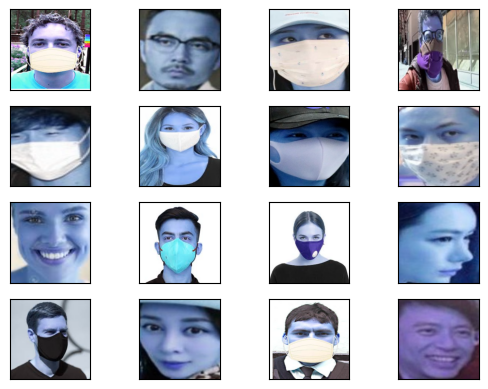

In [ ]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x[i],cmap=plt.cm.binary)

# **Train Test Split**

In [ ]:
x_train , x_test , y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (2401, 224, 224, 3)
Shape of x_test: (601, 224, 224, 3)
Shape of y_train: (2401,)
Shape of y_test: (601,)


# **Label Encoding**

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(class_names.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(class_names.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# **Normalizing the Data**

In [ ]:
x_train = x_train/255.0
x_test = x_test/225.0

# **Building the Neural Network**

In [ ]:
# model = Sequential([
#     Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)),
#     MaxPooling2D(pool_size=(2,2)),

#     Conv2D(64,kernel_size=(3,3),activation='relu'),
#     MaxPooling2D(pool_size=(2,2)),

#     Flatten(),

#     Dense(128,activation='relu'),
#     Dropout(0.5),

#     Dense(64,activation='relu'),
#     Dropout(0.5),

#     Dense(2,activation='sigmoid')
# ])

In [ ]:
from keras.applications import vgg16
r , c = 224 ,224
vgg = vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(r,c,3))
#No need to train pre-trained layers
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
def vgg_model(bottom_model,classes):
  top_model=bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024,activation='relu')(top_model)
  top_model = Dense(512,activation='relu')(top_model)
  top_model = Dense(64,activation='relu')(top_model)
  top_model = Dense(32,activation='relu')(top_model)
  top_model = Dense(2,activation='softmax')(top_model)
  return top_model

In [ ]:
model_head = vgg_model(vgg,2)
model = Model(inputs=vgg.input,outputs=model_head)

# **Neural Network Structure**

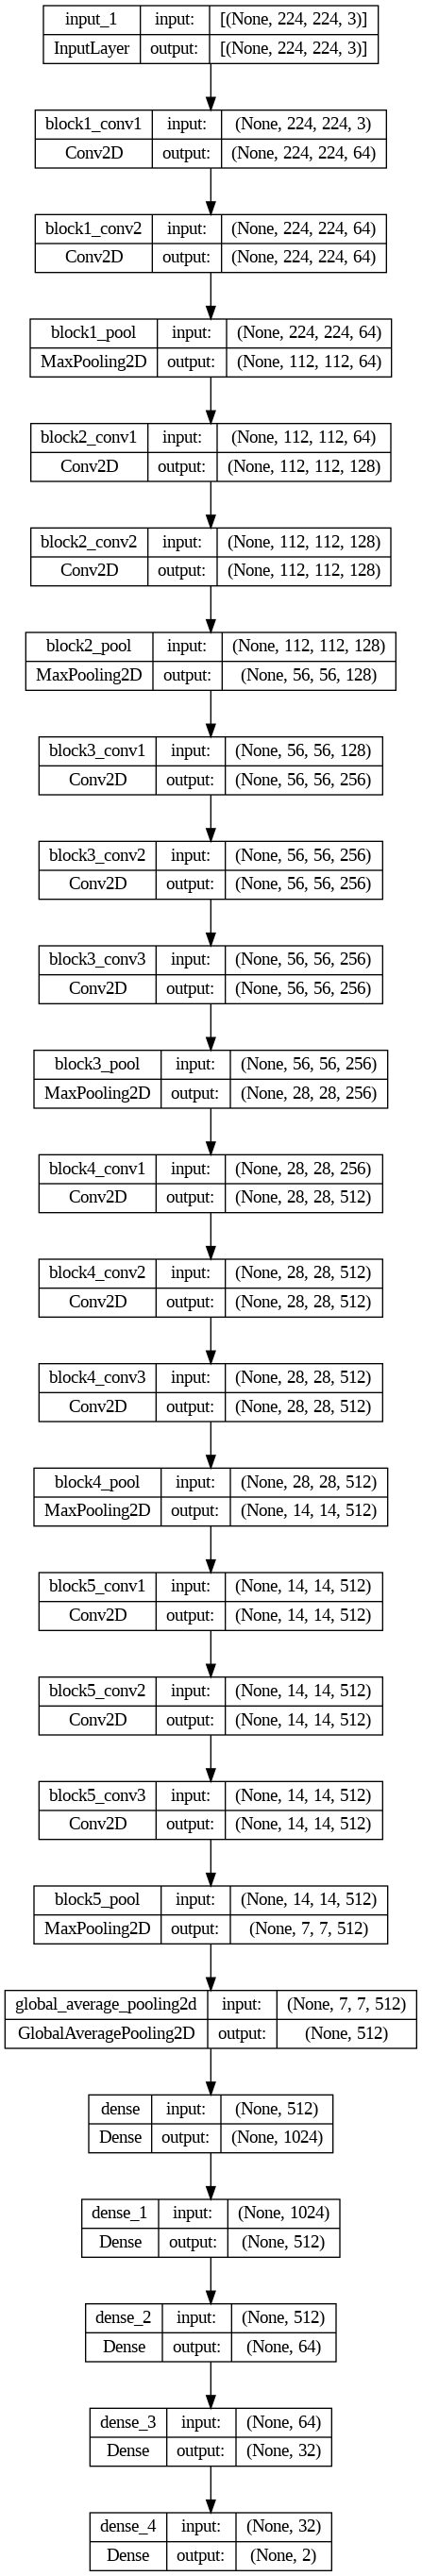

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Model Summary**

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **Compiling the Model**

In [ ]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

# **Training the Model**

In [ ]:
history = model.fit(x_train,y_train,validation_split=0.1,epochs=10)

Epoch 1/10
68/68 [==============================] - 28s 259ms/step - loss: 0.4982 - accuracy: 0.7907 - val_loss: 0.3128 - val_accuracy: 0.8838
Epoch 2/10
68/68 [==============================] - 9s 133ms/step - loss: 0.2720 - accuracy: 0.9023 - val_loss: 0.1921 - val_accuracy: 0.9336
Epoch 3/10
68/68 [==============================] - 9s 135ms/step - loss: 0.1731 - accuracy: 0.9375 - val_loss: 0.1545 - val_accuracy: 0.9419
Epoch 4/10
68/68 [==============================] - 10s 145ms/step - loss: 0.1307 - accuracy: 0.9509 - val_loss: 0.1302 - val_accuracy: 0.9378
Epoch 5/10
68/68 [==============================] - 10s 140ms/step - loss: 0.1033 - accuracy: 0.9648 - val_loss: 0.0996 - val_accuracy: 0.9668
Epoch 6/10
68/68 [==============================] - 10s 141ms/step - loss: 0.0881 - accuracy: 0.9676 - val_loss: 0.1110 - val_accuracy: 0.9627
Epoch 7/10
68/68 [==============================] - 10s 142ms/step - loss: 0.0770 - accuracy: 0.9745 - val_loss: 0.1148 - val_accuracy: 0.9544
E

# **Model Evaluation**

In [ ]:
loss , acc = model.evaluate(x_test,y_test)
print(f'Accuracy on test data: {acc}')

19/19 [==============================] - 8s 408ms/step - loss: 0.1047 - accuracy: 0.9651
Accuracy on test data: 0.9650582075119019


# **Plotting the training loss vs val loss**

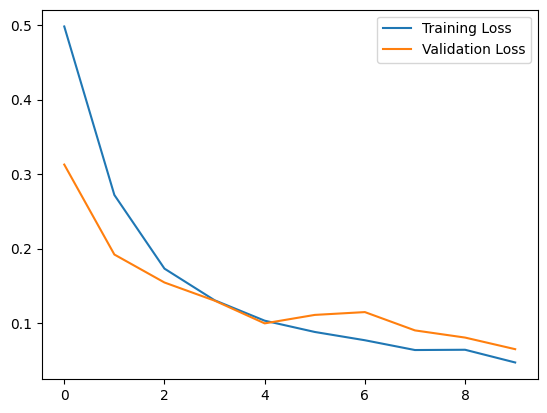

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

# **Plotting the training acc vs val acc**

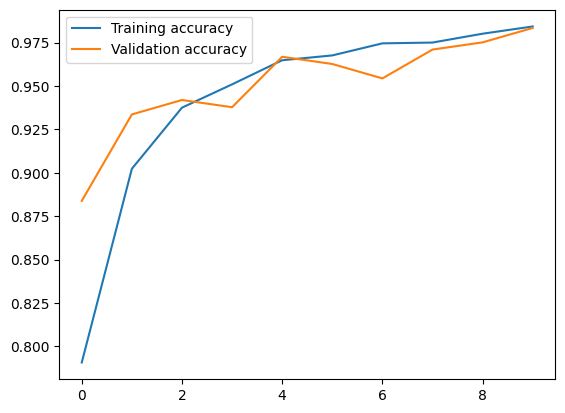

In [ ]:
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'],label='Validation accuracy')
plt.legend()
plt.show()

# **Making Predictions**

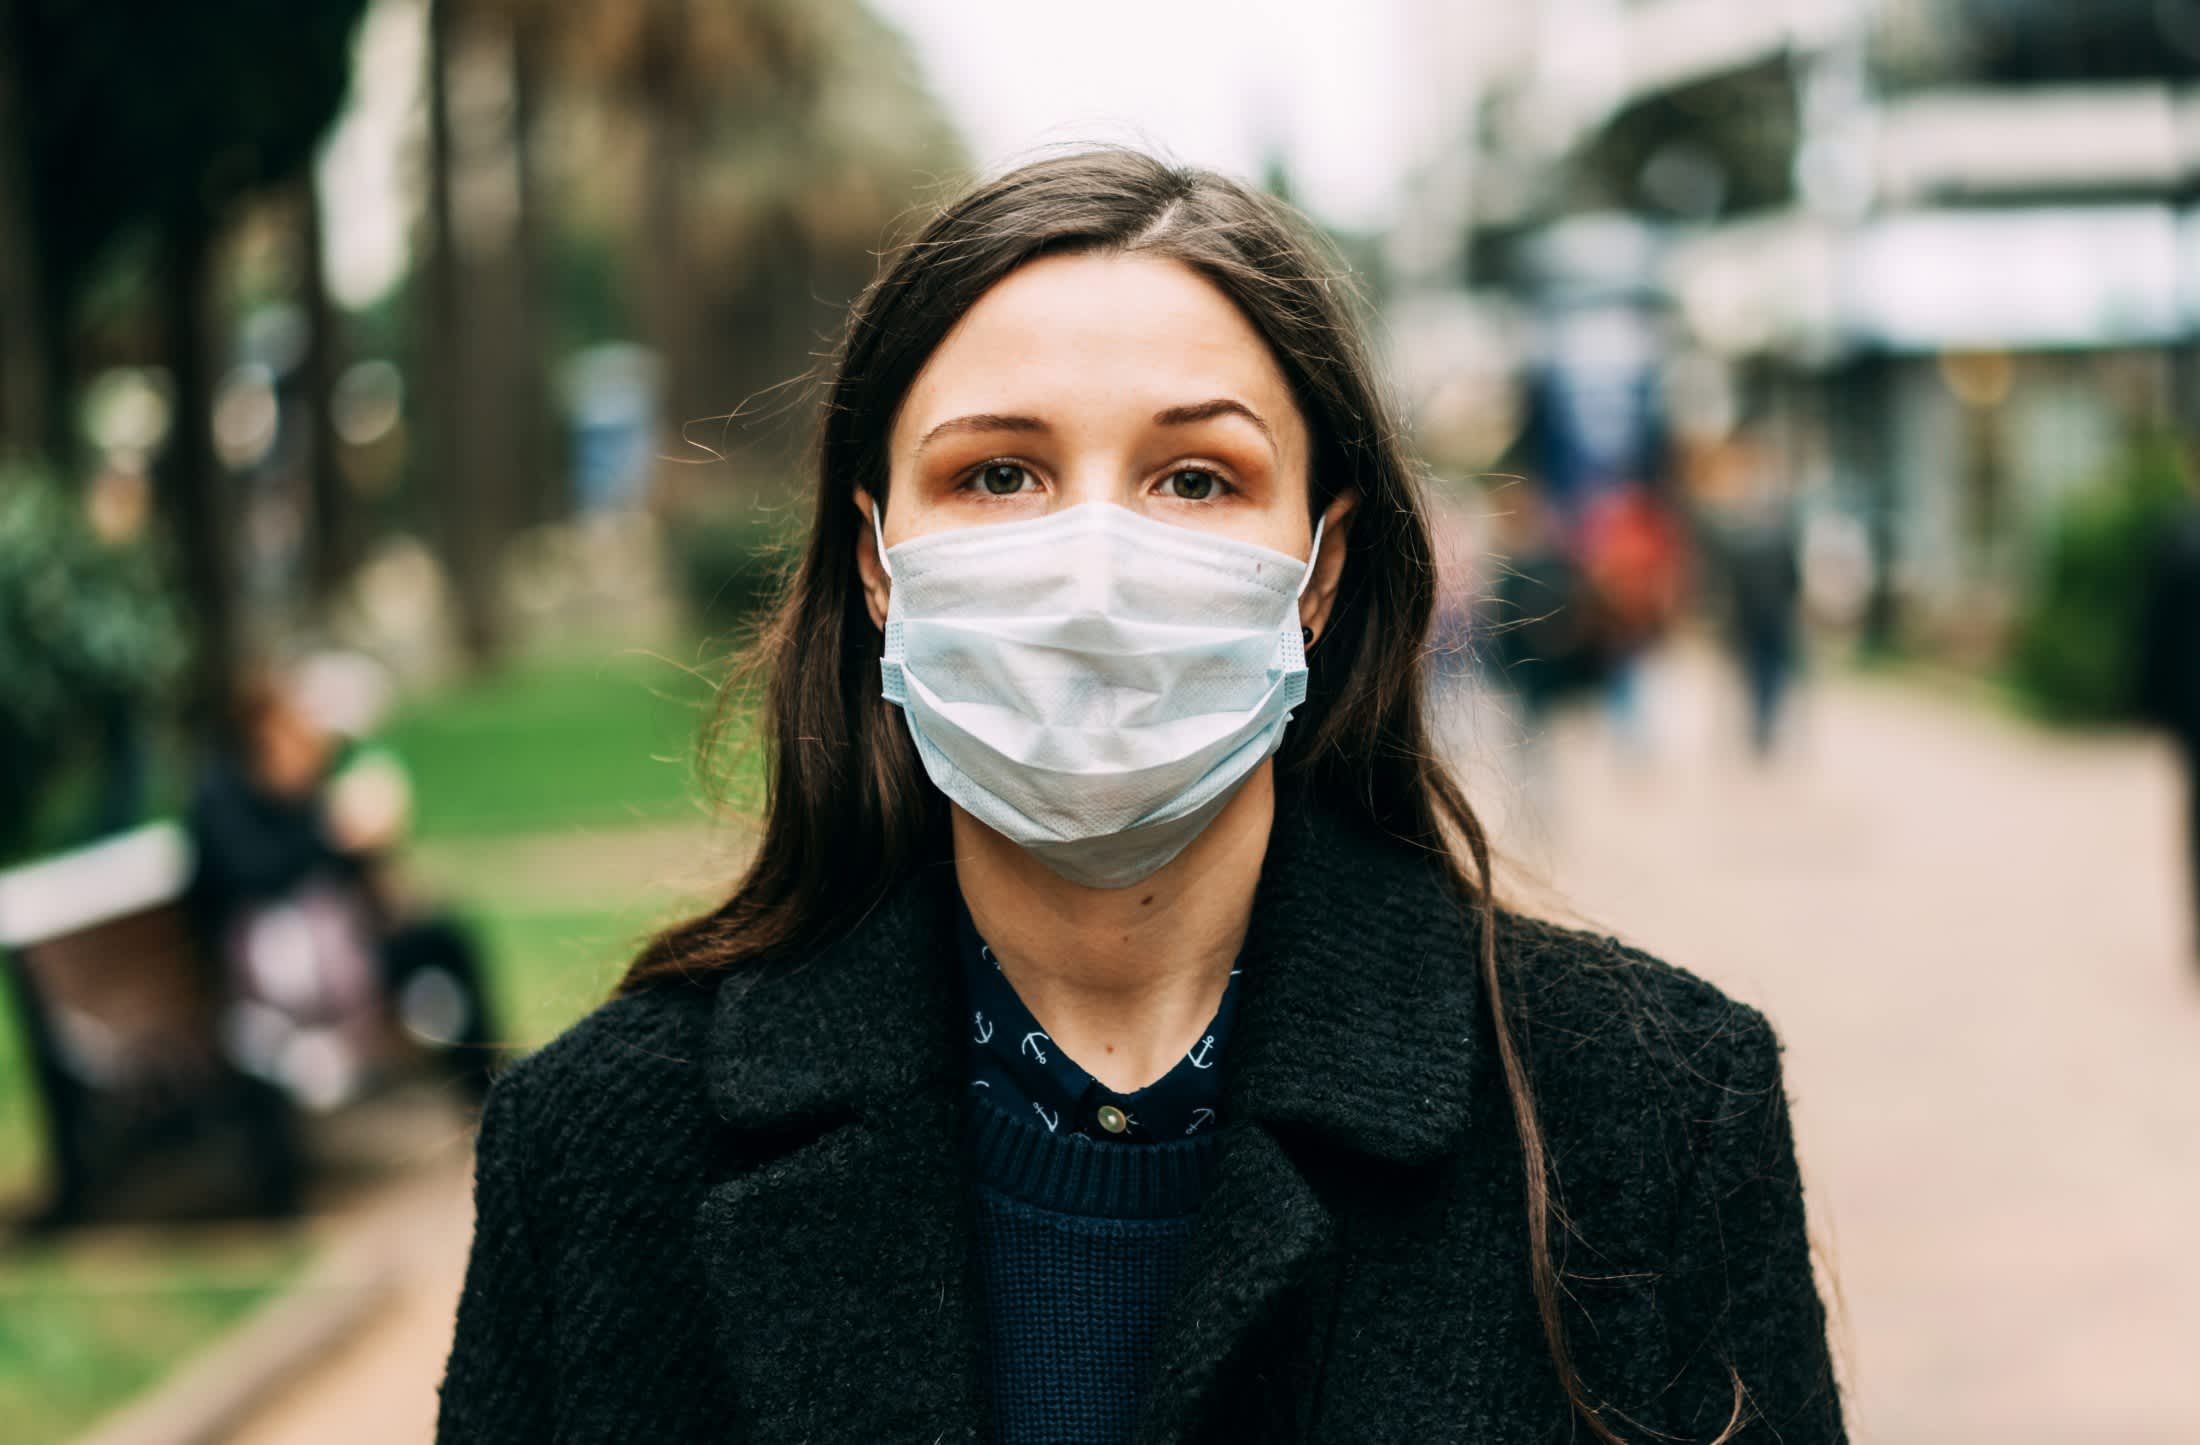

In [ ]:
names = ['with mask' , 'without mask']
with_mask_test = '/content/with_mask_test_image.jpeg'
image = cv2.imread(with_mask_test)
cv2_imshow(image)

# **Resize the Image**

In [ ]:
image = cv2.resize(image,(224,224))
image = np.reshape(image,[1,224,224,3])
image = image/255.0

In [ ]:
pred = model.predict(image)

1/1 [==============================] - 1s 1s/step


In [ ]:
pred

array([[0.9984251 , 0.00157487]], dtype=float32)

In [ ]:
pred_1 = np.argmax(pred)

In [ ]:
print(f"The prediction is: {names[pred_1]}")

The prediction is: with mask


# **On another Image**

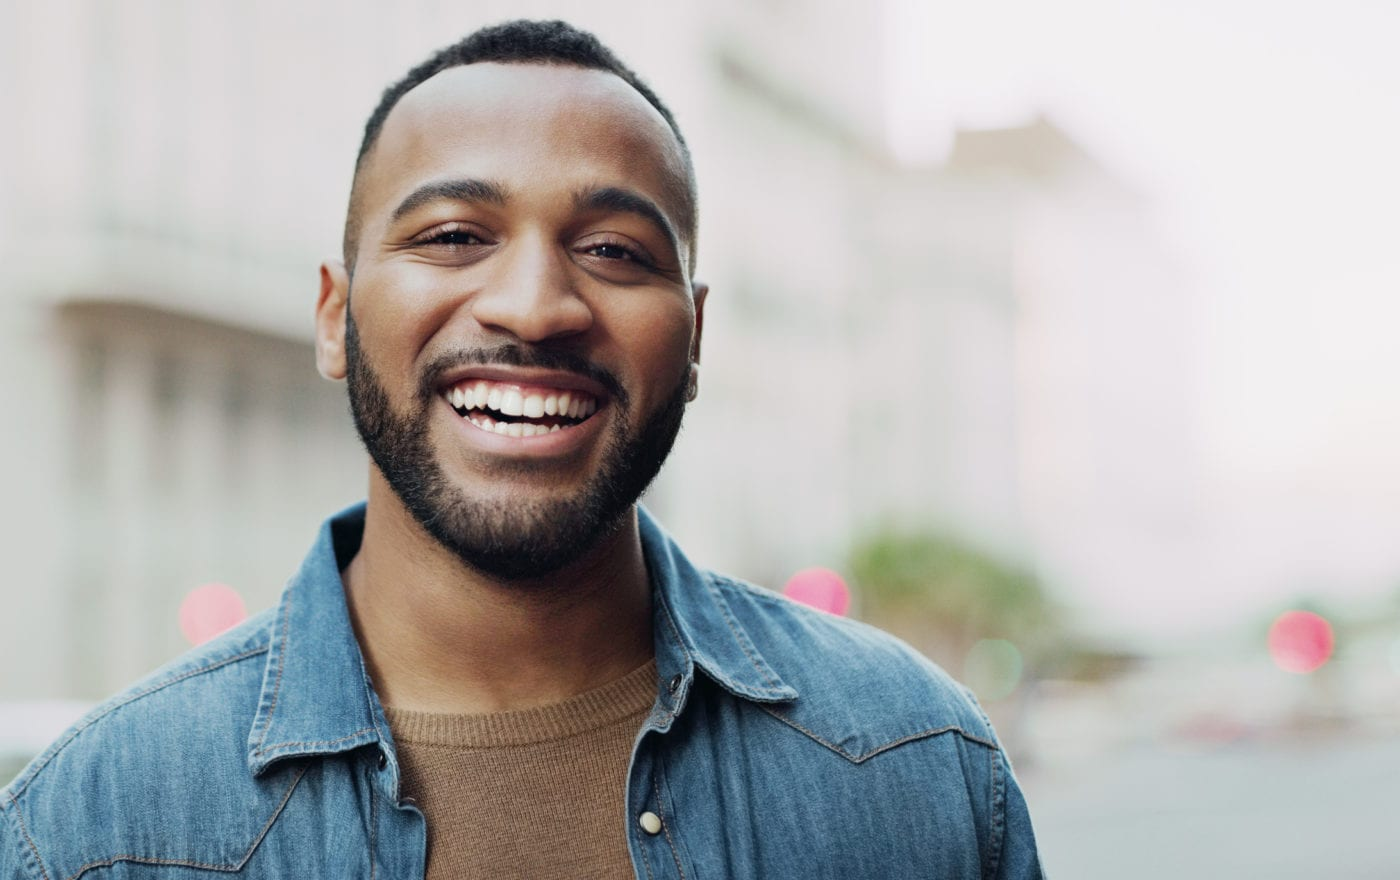

In [ ]:
without_mask_image = '/content/person1.jpeg'
image2 = cv2.imread(without_mask_image)
cv2_imshow(image2)

In [ ]:
image2 = cv2.resize(image2,(224,224))
image2 = np.reshape(image2,[1,224,224,3])
image2 = image2/255.0

In [ ]:
pred2 = model.predict(image2)

1/1 [==============================] - 0s 25ms/step


In [ ]:
pred2

array([[0.00329127, 0.99670875]], dtype=float32)

In [ ]:
pred_2 = np.argmax(pred2)

In [ ]:
print(f"The prediction is: {names[pred_2]}")

The prediction is: without mask


# **Another Image**

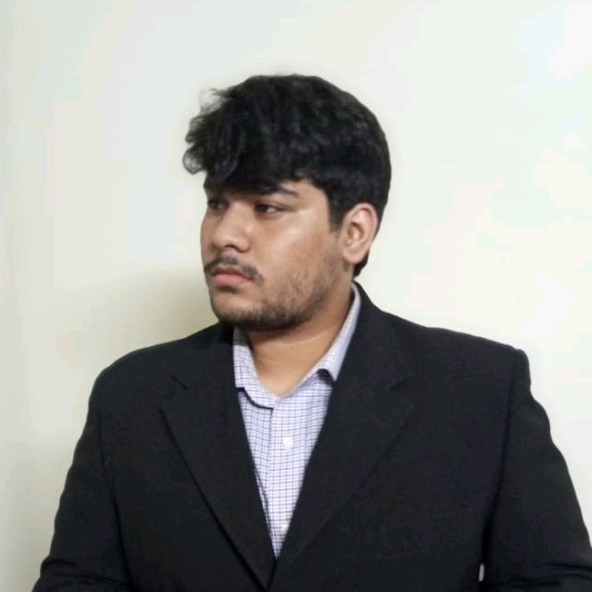

In [ ]:
without_mask_image2 = '/content/without_mask_test.jpeg'
image3 = cv2.imread(without_mask_image2)
cv2_imshow(image3)

In [ ]:
image3 = cv2.resize(image3,(224,224))
image3 = np.reshape(image3,[1,224,224,3])
image3 = image3/255.0

In [ ]:
pred3 = model.predict(image3)

1/1 [==============================] - 0s 19ms/step


In [ ]:
pred3

array([[0.00235678, 0.9976432 ]], dtype=float32)

In [ ]:
pred_3 = np.argmax(pred3)

In [ ]:
print(f"The prediction is: {names[pred_3]}")

The prediction is: without mask


# **Another Image**

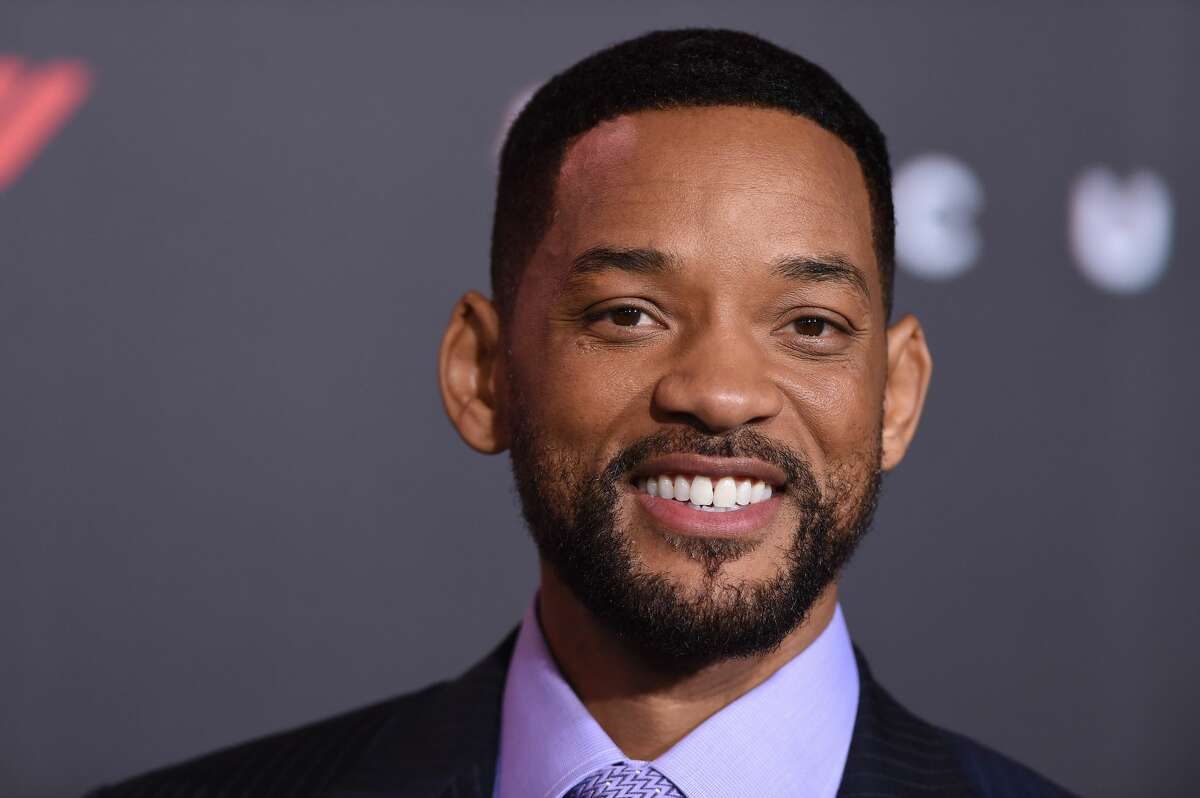

In [ ]:
without_mask_image4 = '/content/person2.jpeg'
image5 = cv2.imread(without_mask_image4)
cv2_imshow(image5)

In [ ]:
image5 = cv2.resize(image5,(224,224))
image5 = np.reshape(image5,[1,224,224,3])
image5 = image5/255.0

In [ ]:
pred5 = model.predict(image5)
pred_5 = np.argmax(pred5)

1/1 [==============================] - 0s 126ms/step


In [ ]:
print(f"The prediction is: {names[pred_5]}")

The prediction is: without mask


# **Final Image**

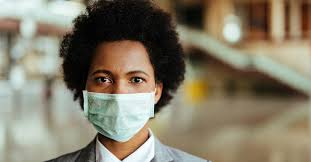

In [ ]:
with_mask_image2 = '/content/mask2.jpeg'
image4 = cv2.imread(with_mask_image2)
cv2_imshow(image4)

In [ ]:
image4 = cv2.resize(image4,(224,224))
image4 = np.reshape(image4,[1,224,224,3])
image4 = image4/255.0

In [ ]:
pred4 = model.predict(image4)

1/1 [==============================] - 0s 19ms/step


In [ ]:
pred_4 = np.argmax(pred4)

In [ ]:
print(f"The prediction is: {names[pred_4]}")

The prediction is: with mask


# **Exporting the Model**

In [ ]:
import pickle

In [ ]:
pickle.dump(model,open('/content/Face_mask_detector','wb'))

In [ ]:
#To load the model use the following command:
#model = pickle.load(open(file path of the downloaded model, 'rb'))